# Style Transfer
The [original paper](https://arxiv.org/pdf/1508.06576v2.pdf).  
The [spec](http://liftothers.org/dokuwiki/doku.php?id=cs501r_f2018:lab5).  
Expect to run for 6000 iterations.

In [1]:
!git clone https://github.com/niazwazir/TestImage.git

Cloning into 'TestImage'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (55/55), done.


In [2]:
cd TestImage/

/content/TestImage


In [3]:
import gc
# import imageio
from IPython.core.ultratb import AutoFormattedTB
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image as pImage
import tensorflow as tf
import cv2
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import traceback

assert torch.cuda.is_available()
__ITB__ = AutoFormattedTB(mode='Verbose', color_scheme='LightBg', tb_offset=1)
np.set_printoptions(precision=2)
torch.set_printoptions(precision=6)
MODEL_PATH = 'cancer_model.params'

## Run the VGG network on the content and style images. Save the activations.

In [0]:
def display_x_tensor(t, title=None):
    """
    Transposes and rescales an input tensor to display as an image.
    Ends with displaying a (h,w,c) ndarray of floats in [0,1].
    Parameters:
        t ((3,h,w) tensor)
    """
    npimg = t.detach().cpu().numpy()
    npimg = np.transpose(npimg, (1,2,0))
    # Rescale
    minimum, maximum = np.min(npimg), np.max(npimg)
    scale = maximum - minimum
    npimg = (npimg - minimum) / scale
    plt.imshow(npimg, interpolation='nearest')
    if title:
        plt.title(title)
    plt.show()

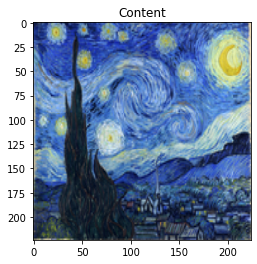

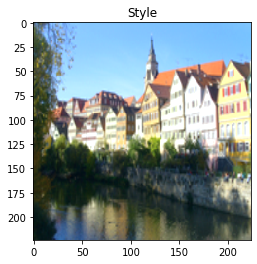

In [6]:
CONTENT_PATH = 'style.png'
STYLE_PATH = 'content.png'

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
 
content_image = pImage.open(CONTENT_PATH)
content_image = load_and_normalize(np.array(content_image)).unsqueeze(0).cuda()
content_image.data.clamp_(-2,2)
 
style_image = pImage.open(STYLE_PATH)
style_image = load_and_normalize(np.array(style_image)).unsqueeze(0).cuda()
style_image.data.clamp_(-2,2)

display_x_tensor(content_image[0], title="Content")
display_x_tensor(style_image[0], title="Style")

In [7]:
class VGGIntermediate(nn.Module):
    def __init__(self, requested=[]):
        super(VGGIntermediate, self).__init__()

        self.intermediates = {}
        self.vgg = models.vgg16(pretrained=True).features.eval()
        for i, m in enumerate(self.vgg.children()):
            if i in requested:
                def curry(i):
                    def hook(module, input, output):
                        self.intermediates[i] = output
                    return hook
                m.register_forward_hook(curry(i))
    
    def forward(self, x):
        self.vgg(x)  
        return self.intermediates

    def foo(self):
        for i, m in enumerate(self.vgg.children()):
            print(i, m)
            
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", 
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]
def get_layer_index(name):
    return vgg_names.index(name)

requested_layer_names = ["conv4_2", "conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
requested_vals = [get_layer_index(name) for name in requested_layer_names]
vgg = VGGIntermediate(requested=requested_vals).cuda()
content_filters = vgg(content_image)
style_filters = vgg(style_image)
print (content_filters.keys())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



dict_keys([0, 5, 10, 17, 19, 24])


## Content Loss
![](https://i.imgur.com/uoVn3UR.png)
Match the content representation on layer `conv4_2`.

## Style Loss
![Imgur](https://i.imgur.com/TxUD6hE.png)  
Style loss is a weighted combination among the layers.  
Style loss is computed from ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’ (wl =
1/5 in those layers, wl = 0 in all other layers)

In [0]:
alpha, beta = 1, 1e6

class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
        
    def forward(self, input):
        return F.mse_loss(input, self.target)

def get_content_filters(im):
    content_layer_idx = 0
    return vgg(im)[content_layer_idx]

content_objective = ContentLoss(get_content_filters(content_image))
def content_loss(pastiche_image):
    return content_objective(get_content_filters(pastiche_image))

#################################################################

class StyleLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
        self.gram_target = self.gram(self.target)
        
    def gram(self, input):
        a, b, c, d = input.size()
        features = input.view(a*b, c*d)
        return torch.mm(features, features.t())
    
    def forward(self, input):
        a, b, c, d = input.size()
        weight = 1/5
        K = 1/(4*(a*b*c*d)**2)
        return weight * K * F.mse_loss(self.gram(input), self.gram_target)

style_layer_indices = [5, 10, 17, 19, 24]
def get_style_filters(im, layer_idx):
    return vgg(im)[layer_idx]

style_objectives = [
    StyleLoss(get_style_filters(style_image, layer_idx))
    for layer_idx in style_layer_indices
]
def style_loss(pastiche_image):
    total_loss = 0
    for layer_idx, objective in zip(style_layer_indices, style_objectives):
        total_loss += objective(get_style_filters(pastiche_image, layer_idx))
    return total_loss

############################################################
        
def total_loss(pastiche_image):
    return alpha*content_loss(pastiche_image), beta*style_loss(pastiche_image)

## Adam optimizer, init variables, reload VGG weights, load content image as pastiche.
The training process has been cleared, but the results can be seen below.

loss: 0.000, style: 32.332, content: 0.348, min:-7.444, max:8.441:   0%|          | 1/500 [00:00<01:04,  7.71it/s]

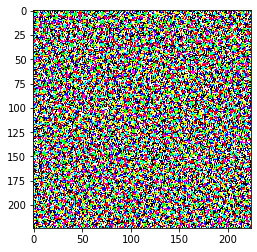

loss: 0.000, style: 0.442, content: 0.338, min:-0.157, max:1.145:  20%|██        | 100/500 [00:07<00:30, 13.27it/s]

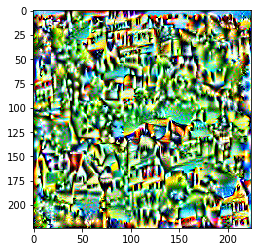

loss: 0.000, style: 0.381, content: 0.334, min:-0.253, max:1.196:  40%|████      | 200/500 [00:15<00:22, 13.33it/s]

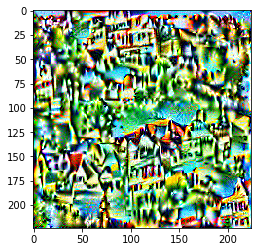

loss: 0.000, style: 0.291, content: 0.336, min:-0.125, max:1.131:  60%|██████    | 300/500 [00:23<00:15, 13.24it/s]

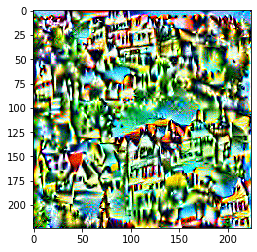

loss: 0.000, style: 0.281, content: 0.337, min:-0.108, max:1.133:  80%|████████  | 400/500 [00:31<00:07, 13.25it/s]

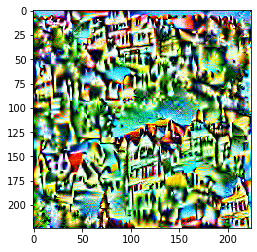

loss: 0.000, style: 0.355, content: 0.338, min:-0.143, max:1.173: 100%|██████████| 500/500 [00:38<00:00, 13.31it/s]


In [9]:
pastiche_image = content_image.clone().requires_grad_()
pastiche_image = torch.normal(torch.zeros((1,3,224,224))).cuda().requires_grad_()
optimizer = optim.Adam([pastiche_image], lr=10.0) # Todo: possibly adjust the learning rate lower
objective = ContentLoss(content_image)

num_epochs = 500
clamp = (0,1)

with tqdm(total=num_epochs, position=0) as loop:
    for i in range(num_epochs):
        pastiche_image.data.clamp_(*clamp)
        optimizer.zero_grad()
        c_loss, s_loss = total_loss(pastiche_image)
        loss = s_loss
        loss = style_loss(pastiche_image)
        loss.backward()
        optimizer.step()

        loop.set_description("loss: {:.3f}, style: {:.3f}, content: {:.3f}, min:{:.3f}, max:{:.3f}".format(
            loss.item(), s_loss.item(), c_loss.item(), pastiche_image.min(), pastiche_image.max()))
        loop.update(1)

        if i%100 == 0:
            pastiche_image.data.clamp_(*clamp)
            display_x_tensor(pastiche_image[0])

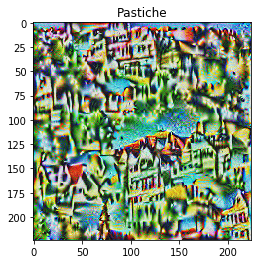

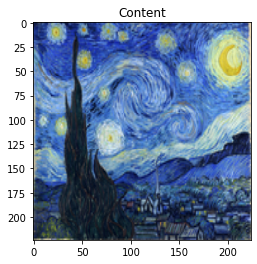

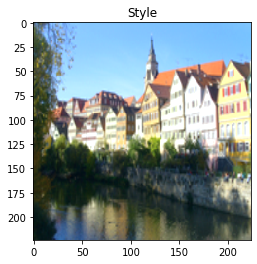

In [10]:
display_x_tensor(pastiche_image[0], title="Pastiche")
display_x_tensor(content_image[0], title="Content")
display_x_tensor(style_image[0], title="Style")